In [172]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/star2-dataset/train.ftr
/kaggle/input/star2-dataset/test.ftr
/kaggle/input/star2-dataset/sample_submission.csv
/kaggle/input/star2-processed-dataset/processed_test2.ftr
/kaggle/input/star2-processed-dataset/processed_test.ftr
/kaggle/input/star2-processed-dataset/processed_train2.ftr
/kaggle/input/star2-processed-dataset/processed_train.ftr


In [173]:
# Standard libraries
import os
import numpy as np
import random
import pandas as pd
import time
import re
import gc # memory

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import cv2 

# Correlation
from scipy.cluster import hierarchy as hc # dendrogram

# Model
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras import optimizers, regularizers
from keras.layers import Input, Dense, Lambda
from keras.models import Sequential, Model, load_model 
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import metrics
from sklearn.tree import export_graphviz
from tqdm import tqdm                       # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산 

# For notebook plotting
%matplotlib inline

import warnings                             
warnings.filterwarnings("ignore")           # 경고 문구 미표시

In [174]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 3000)
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_colwidth', 3000)

In [175]:
# Detect hardware, return appropriate distribution strategy
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# 1. Loading Data

In [176]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [177]:
# 전처리된 데이터셋 불러오기 
train = pd.read_feather("/kaggle/input/star2-processed-dataset/processed_train2.ftr")
train = reduce_mem_usage(train)

Memory usage of dataframe is 23.89 MB --> 6.32 MB (Decreased by 73.5%)


In [178]:
train.head()

,game_id,VESPENE_0,SUPPLY_0,WORKER_0,BASE_0,BUILDING_0,DEFENSE_0,ARMY_0,UPGRADE_0,Minerals_0,Gas_0,Supply_0,Control_key_0,Ability_0,AddToControlGroup_0,Camera_0,ControlGroup_0,GetControlGroup_0,Right Click_0,Selection_0,SetControlGroup_0,Micro_0,Macro_0,APM_0,Player_sight_0,Resource_0,Play_time_0,P_0,T_0,Z_0,VESPENE_1,SUPPLY_1,WORKER_1,BASE_1,BUILDING_1,DEFENSE_1,ARMY_1,UPGRADE_1,Minerals_1,Gas_1,Supply_1,Control_key_1,Ability_1,AddToControlGroup_1,Camera_1,ControlGroup_1,GetControlGroup_1,Right Click_1,Selection_1,SetControlGroup_1,Micro_1,Macro_1,APM_1,Player_sight_1,Resource_1,Play_time_1,P_1,T_1,Z_1,delta_VESPENE,delta_SUPPLY,delta_WORKER,delta_BASE,delta_BUILDING,delta_DEFENSE,delta_ARMY,delta_UPGRADE,delta_Minerals,delta_Gas,delta_Supply,delta_Control_key,delta_Ability,delta_AddToControlGroup,delta_Camera,delta_ControlGroup,delta_GetControlGroup,delta_Right Click,delta_Selection,delta_SetControlGroup,delta_Micro,delta_Macro,delta_APM,delta_Player_sight,delta_Resource,delta_Play_time,winner
0,0,2,4,9,2,7,0,5,1,2800,500,16.00,2,34,2,444,0,24,35,50,3,31,30,150,1437.00,3300,7.24,0.00,1.00,0.00,2,3,6,2,4,0,7,0,2000,400,17.00,4,34,0,425,0,3,28,57,1,8,24,127,1359.00,2400,7.24,0.00,1.00,0.00,0,-1,-3,0,-3,0,2,-1,-800,-100,1.00,2,0,-2,-19,0,-21,-7,7,-2,-23,-6,-23,-78.00,-900,0.00,1.00
1,1,3,8,22,1,11,0,7,3,5450,1325,40.00,9,77,1,627,0,162,160,186,10,182,55,605,2361.00,6775,9.59,1.00,0.00,0.00,2,2,17,3,7,3,12,2,4475,1050,37.00,6,67,0,858,0,31,131,116,8,45,48,359,2967.00,5525,9.59,0.00,1.00,0.00,-1,-6,-5,2,-4,3,5,-1,-975,-275,-3.00,-3,-10,-1,231,0,-131,-29,-70,-2,-137,-7,-246,606.00,-1250,0.00,1.00
2,2,6,5,19,1,6,2,5,2,4575,1125,32.00,13,69,6,413,0,99,160,90,14,132,46,451,1719.00,5700,9.59,1.00,0.00,0.00,3,7,23,3,8,2,9,4,4550,750,35.00,10,85,5,725,2,109,204,232,9,135,59,656,2787.00,5300,9.59,0.00,0.00,1.00,-3,2,4,2,2,0,4,2,-25,-375,3.00,-3,16,-1,312,2,10,44,142,-5,3,13,205,1068.00,-400,0.00,0.00
3,3,1,6,7,4,9,0,20,2,4925,1300,39.00,17,82,0,713,0,132,276,180,6,155,49,693,2967.00,6225,9.59,0.00,1.00,0.00,4,7,24,1,8,0,5,1,4600,825,35.00,25,89,0,388,0,710,268,148,19,754,50,1259,1968.00,5425,9.57,1.00,0.00,0.00,3,1,17,-3,-1,0,-15,-1,-325,-475,-4.00,8,7,0,-325,0,578,-8,-32,13,599,1,566,-999.00,-800,-0.02,0.00
4,4,2,2,14,2,4,0,5,1,2500,375,22.00,18,57,1,430,0,224,177,67,10,253,30,554,1821.00,2875,5.39,0.00,1.00,0.00,1,4,13,2,3,0,3,1,2300,200,17.50,4,36,4,272,0,99,106,126,8,115,27,383,1134.00,2500,5.43,0.00,0.00,1.00,-1,2,-1,0,-1,0,-2,0,-200,-175,-4.50,-14,-21,3,-158,0,-125,-71,59,-2,-138,-3,-171,-687.00,-375,0.04,0.00


# 2. Initial Exploration

In [179]:
train.describe().drop('count')

,game_id,VESPENE_0,SUPPLY_0,WORKER_0,BASE_0,BUILDING_0,DEFENSE_0,ARMY_0,UPGRADE_0,Minerals_0,Gas_0,Supply_0,Control_key_0,Ability_0,AddToControlGroup_0,Camera_0,ControlGroup_0,GetControlGroup_0,Right Click_0,Selection_0,SetControlGroup_0,Micro_0,Macro_0,APM_0,Player_sight_0,Resource_0,Play_time_0,P_0,T_0,Z_0,VESPENE_1,SUPPLY_1,WORKER_1,BASE_1,BUILDING_1,DEFENSE_1,ARMY_1,UPGRADE_1,Minerals_1,Gas_1,Supply_1,Control_key_1,Ability_1,AddToControlGroup_1,Camera_1,ControlGroup_1,GetControlGroup_1,Right Click_1,Selection_1,SetControlGroup_1,Micro_1,Macro_1,APM_1,Player_sight_1,Resource_1,Play_time_1,P_1,T_1,Z_1,delta_VESPENE,delta_SUPPLY,delta_WORKER,delta_BASE,delta_BUILDING,delta_DEFENSE,delta_ARMY,delta_UPGRADE,delta_Minerals,delta_Gas,delta_Supply,delta_Control_key,delta_Ability,delta_AddToControlGroup,delta_Camera,delta_ControlGroup,delta_GetControlGroup,delta_Right Click,delta_Selection,delta_SetControlGroup,delta_Micro,delta_Macro,delta_APM,delta_Player_sight,delta_Resource,delta_Play_time,winner
mean,19434.03,1.83,3.66,11.56,1.57,4.43,0.72,6.71,1.00,2750.14,474.13,21.88,9.75,48.91,1.92,408.18,0.40,129.77,149.25,123.18,4.37,146.21,31.48,467.55,1672.30,3224.27,7.30,0.28,0.39,0.33,1.84,3.67,11.54,1.55,4.47,0.73,6.71,1.00,2757.85,477.98,21.90,9.81,49.01,1.93,407.20,0.39,129.32,148.92,122.38,4.41,145.86,31.51,466.18,1668.36,3235.84,7.30,0.28,0.39,0.33,0.01,0.01,-0.02,-0.01,0.04,0.00,0.00,0.00,7.71,3.85,0.02,0.06,0.10,0.01,-0.98,-0.00,-0.45,-0.33,-0.80,0.03,-0.35,0.03,-1.37,-3.94,11.56,-0.00,0.50
std,11221.14,1.14,2.16,6.25,1.22,2.80,1.29,4.99,1.23,1323.59,375.99,12.27,10.78,28.07,3.04,221.93,3.44,186.25,97.86,85.90,4.79,194.35,15.13,325.78,832.59,1645.70,2.58,0.45,0.49,0.47,1.16,2.17,6.23,1.22,2.82,1.32,5.02,1.22,1331.39,377.75,12.32,10.77,28.19,3.03,222.42,3.50,185.69,97.41,85.42,4.80,193.75,15.17,323.72,834.25,1656.22,2.58,0.45,0.49,0.47,1.38,2.29,5.51,1.44,2.89,1.75,4.97,1.39,898.65,342.78,9.89,10.63,18.48,4.00,214.72,4.87,219.56,87.69,95.49,5.69,223.92,9.58,292.82,708.97,1130.93,0.10,0.50
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,-6.00,-17.00,-29.00,-10.00,-15.00,-18.00,-34.00,-10.00,-4900.00,-1900.00,-66.00,-105.00,-141.00,-35.00,-1589.00,-241.00,-2222.00,-626.00,-733.00,-57.00,-2222.00,-51.00,-2315.00,-4845.00,-6050.00,-5.38,0.00
25%,9715.75,1.00,2.00,7.00,1.00,2.00,0.00,3.00,0.00,1725.00,150.00,12.00,2.00,27.00,0.00,239.00,0.00,11.00,71.00,60.00,1.00,20.00,20.00,225.00,1023.00,1925.00,5.28,0.00,0.00,0.00,1.00,2.00,7.00,1.00,2.00,0.00,3.00,0.00,1725.00,150.00,12.00,2.00,27.00,0.00,238.00,0.00,11.00,71.00,60.00,1.00,20.00,20.00,223.00,1023.00,1925.00,5.28,0.00,0.00,0.00,-1.00,-1.00,-3.00,-1.00,-2.00,-1.00,-2.00,-1.00,-500.00,-175.00,-5.00,-4.00,-9.00,-2.00,-121.00,0.00,-58.00,-48.00,-49.00,-3.00,-62.00,-5.00,-141.00,-411.75,-625.00,0.00,0.00
50%,19434.50,2.00,3.00,11.00,1.00,4.00,0.00,6.00,1.00,2700.00,400.00,21.00,6.00,46.00,0.00,391.00,0.00,45.00,133.00,102.00,3.00,61.00,31.00,391.00,1656.00,3150.00,8.15,0.00,0.00,0.00,2.00,3.00,11.00,1.00,4.00,0.00,6.00,1.00,2725.00,425.00,21.00,6.00,46.00,0.00,390.00,0.00,45.00,134.00,102.00,3.00,62.00,31.00,393.00,1653.00,3175.00,8.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-3.00,0.00,0.00,1.00
75%,29149.25,2.00,5.00,15.00,2.00,6.00,1.00,10.00,2.00,3675.00,725.00,30.00,14.00,66.00,3.00,550.00,0.00,175.00,210.00,167.00,6.00,198.00,42.00,632.00,2265.00,4375.00,9.59,1.00,1.00,1.00,3.00,5.00,15.00,2.00,6.00,1.00,10.00,2.00,3700.00,725.00,30.00,14.00,67.00,3.00,548.00,0.00,174.00,211.00,165.00,6.00,197.00,42.00,633.00,2265.00,4400.00,9.59,1.00,1.00,1.00,1.00,1.00,3.00,1.00,2.00,1.00,2.00,1.00,500.00,175.00,5.00,4.00,9.00,2.00,117.00,0.00,58.00,47.00,47

# 3. Data Cleaning

## Handle Missing value

In [180]:
# train[((train.event == 'AddToControlGroup') | (train.event == 'SetControlGroup') | (train.event == 'GetControlGroup') | (train.event == 'ControlGroup')) == False].isna().sum()

# 4. EDA

## Use unit information in StarCraft 2

In [181]:
# Protoss
def P_info():
    P_dict = {
    # VESPENE
    'BuildAssimilator':[75,0,0,'VESPENE'],
    
    # SUPPLY
    'BuildPylon':[100,0,0,'SUPPLY'],
    
    # WORKER
    'TrainProbe':[50,0,1,'WORKER'],
    
    # BASE 
    'BuildNexus':[400,0,0,'BASE'],
    
    # BUILDING
    'BuildGateway':[150,0,0,'BUILDING'],       'BuildTemplarArchive':[150,200,0,'BUILDING'],   'BuildDarkShrine':[150,150,0,'BUILDING'], 
    'BuildRoboticsBay':[200,200,0,'BUILDING'], 'BuildRoboticsFacility':[150,100,0,'BUILDING'], 'BuildStargate':[150,150,0,'BUILDING'], 
    'BuildFleetBeacon':[300,200,0,'BUILDING'], 'BuildForge':[150,0,0,'BUILDING'],              'BuildCyberneticsCore':[150,0,0,'BUILDING'], 
    'BuildTwilightCouncil':[150,100,0,'BUILDING'],'BuildTemplarArchive':[150,200,0,'BUILDING'],'BuildDarkShrine':[150,150,0,'BUILDING'], 
    'BuildFleetBeacon':[300,200,0,'BUILDING'], 'BuildRoboticsBay':[150,150,0,'BUILDING'],
    
    # DEFENSE
    'BuildPhotonCannon':[150,0,0,'DEFENSE'], 'BuildShieldBattery':[100,0,0,'DEFENSE'],
    
    # ARMY
    'TrainZealot':[100,0,2,'ARMY'],        'TrainSentry':[50,100,2,'ARMY'],      'TrainStalker':[125,50,2,'ARMY'],  'TrainHighTemplar':[50,150,2,'ARMY'], 
    'TrainDarkTemplar':[125,125,2,'ARMY'], 'TrainImmortal':[250,100,4,'ARMY'],   'TrainColossus':[300,200,6,'ARMY'],'TrainArchon':[0,0,4,'ARMY'],
    'TrainObserver':[25,75,1,'ARMY'],      'TrainWarpPrism':[200,0,2,'ARMY'],    'TrainPhoenix':[150,100,2,'ARMY'], 'TrainMothershipCore':[100,100,2,'ARMY'],
    'TrainVoidRay':[250,150,4,'ARMY'],     'TrainOracle':[150,150,3,'ARMY'],     'TrainTempest':[250,175,5,'ARMY'], 'TrainCarrier':[350,250,6,'ARMY'],
    'TrainInterceptor':[15,0,0,'ARMY'],    'TrainMothership':[400,400,8,'ARMY'], 'TrainAdept':[100,25,2,'ARMY'],    'TrainDisruptor':[150,150,3,'ARMY'],
    
    # UPGRADE    
    'UpgradeGroundWeapons1':[100,100,0,'UPGRADE'], 'UpgradeGroundWeapons2':[150,150,0,'UPGRADE'],'UpgradeGroundWeapons3':[200,200,0,'UPGRADE'], 
    'UpgradeGroundArmor1':[100,100,0,'UPGRADE'],   'UpgradeGroundArmor2':[150,150,0,'UPGRADE'],  'UpgradeGroundArmor3':[200,200,0,'UPGRADE'],
    'UpgradeShields1':[150,150,0,'UPGRADE'],       'UpgradeShields2':[225,225,0,'UPGRADE'],      'UpgradeShields3':[300,300,0,'UPGRADE'],
    'UpgradeAirWeapons1':[100,100,0,'UPGRADE'],    'UpgradeAirWeapons2':[175,175,0,'UPGRADE'],   'UpgradeAirWeapons3':[250,250,0,'UPGRADE'],
    'UpgradeAirArmor1':[150,150,0,'UPGRADE'],      'UpgradeAirArmor2':[225,225,0,'UPGRADE'],     'UpgradeAirArmor3':[300,300,0,'UPGRADE'],
    'ResearchCharge':[100,100,0,'UPGRADE'],        'ResearchBlink':[100,100,0,'UPGRADE'],        'ResearchResonatingGlaives':[100,100,0,'UPGRADE'], 
    'ResearchPsiStormTech':[200,200,0,'UPGRADE'],  'ResearchGraviticBoosters':[100,100,0,'UPGRADE'], 'ResearchGraviticDrive':[100,100,0,'UPGRADE'],      
    'ResearchExtendedThermalLance':[150,150,0,'UPGRADE'],  'ResearchAnionPulseCrystals':[150,150,0,'UPGRADE'],    'ResearchFluxVanes':[100,100,0,'UPGRADE']
    
    }
               
    return P_dict

In [182]:
# Terran
def T_info():
    T_dict = {
    # VESPENE
    'BuildRefinery':[75,0,0,'VESPENE'],
    
    # SUPPLY
    'BuildSupplyDepot':[100,0,0,'SUPPLY'],
   
    # WORKER
    'TrainSCV':[50,0,1,'WORKER'], 'TrainMule':[0,0,0,'WORKER'],
    
    # BASE
    'BuildCommandCenter':[400,0,0,'BASE'], 'UpgradeToPlanetaryFortress':[150,150,0,'BASE'], 'UpgradeToOrbitalCommand':[150,0,0,'BASE'],
    
    # BUILDING
    'BuildBarracks':[150,0,0,'BUILDING'],        'BuildFactory':[150,100,0,'BUILDING'],      'BuildGhostAcademy':[150,50,0,'BUILDING'], 'BuildArmory':[150,100,0,'BUILDING'],
    'BuildStarport':[150,100,0,'BUILDING'],      'BuildFusionCore':[150,150,0,'BUILDING'],   'BuildEngineeringBay':[125,0,0,'BUILDING'], 
    'BuildSensorTower':[125,100,0,'BUILDING'],   'BuildFactoryTechLab':[50,25,0,'BUILDING'], 'BuildFactoryReactor':[50,50,0,'BUILDING'],  
    'BuildBarracksTechLab':[50,25,0,'BUILDING'], 'BuildBarracksReactor':[50,50,0,'BUILDING'],
   
    # DEFENSE
    'BuildMissileTurret':[100,0,0,'DEFENSE'], 'BuildAutoTurret':[0,0,0,'DEFENSE'], 'BuildPointDefenseDrone':[0,0,0,'DEFENSE'], 'BuildBunker':[100,0,0,'DEFENSE'],
    
    # ARMY
    'TrainMarine':[50,0,1,'ARMY'],   'TrainMarauder':[100,25,2,'ARMY'],       'TrainReaper':[50,50,1,'ARMY'],    'TrainGhost':[150,125,2,'ARMY'], 
    'BuildHellion':[100,0,2,'ARMY'], 'BuildHellbat':[100,0,2,'ARMY'],         'BuildWidowMine':[75,25,2,'ARMY'], 'BuildSiegeTank':[150,125,3,'ARMY'],
    'BuildThor':[300,200,6,'ARMY'],  'TrainViking':[150,75,2,'ARMY'],         'TrainMedivac':[100,100,2,'ARMY'], 'TrainBanshee':[150,100,3,'ARMY'],
    'TrainRaven':[100,200,2,'ARMY'], 'TrainBattlecruiser':[400,300,6,'ARMY'], 'TrainCyclone':[150,100,3,'ARMY'], 'TrainLiberator':[150,150,3,'ARMY'],
    
    # UPGRADE
    'ResearchNeosteelArmor':[150,150,0,'UPGRADE'],                    'ResearchNeosteelFrame':[100,100,0,'UPGRADE'],           'ResearchHiSecAutoTracking':[100,100,0,'UPGRADE'],
    'UpgradeTerranInfantryWeapons1':[100,100,0,'UPGRADE'],            'UpgradeTerranInfantryWeapons2':[175,175,0,'UPGRADE'],   'UpgradeTerranInfantryWeapons3':[250,250,0,'UPGRADE'],
    'UpgradeTerranInfantryArmor1':[100,100,0,'UPGRADE'],              'UpgradeTerranInfantryArmor2':[175,175,0,'UPGRADE'],     'UpgradeTerranInfantryArmor3':[250,250,0,'UPGRADE'],
    'UpgradeStructureArmor':[150,150,0,'UPGRADE'],                    'ResearchPersonalCloaking':[150,150,0,'UPGRADE'],        'ResearchEnhancedShockwaves':[150,150,0,'UPGRADE'],
    'TrainNuke':[100,100,0,'UPGRADE'],                                'ResearchRapidReignitionSystem':[100,100,0,'UPGRADE'],
    'UpgradeVehicleWeapons1':[100,100,0,'UPGRADE'],                   'UpgradeVehicleWeapons2':[175,175,0,'UPGRADE'],           'UpgradeVehicleWeapons3':[250,250,0,'UPGRADE'],
    'UpgradeShipWeapons1':[100,100,0,'UPGRADE'],                      'UpgradeShipWeapons2':[175,175,0,'UPGRADE'],              'UpgradeShipWeapons3':[250,250,0,'UPGRADE'],
    'ResearchTerranVehicleAndShipArmorsLevel1':[100,100,0,'UPGRADE'], 'ResearchTerranVehicleAndShipArmorsLevel2':[175,175,0,'UPGRADE'],
    'ResearchTerranVehicleAndShipArmorsLevel1':[250,250,0,'UPGRADE'], 'ResearchWeaponRefit':[150,150,0,'UPGRADE'],                 'ResearchAdvancedBallistics':[150,150,0,'UPGRADE'], 
    'ResearchCombatShield':[100,100,0,'UPGRADE'],                     'ResearchStimpack':[100,100,0,'UPGRADE'],                    'ResearchConcussiveShells':[50,50,0,'UPGRADE'],
    'ResearchInfernalPreIgniter':[100,100,0,'UPGRADE'],               'ResearchMagFieldAccelerator':[100,100,0,'UPGRADE'],         'ResearchDrillingClaws':[75,75,0,'UPGRADE'],
    'ResearchSmartServos':[100,100,0,'UPGRADE'],                      'ResearchCorvidReactor':[150,150,0,'UPGRADE'],               'ResearchCloakingField':[100,100,0,'UPGRADE'],
    'ResearchHyperflightRotors':[150,150,0,'UPGRADE'],                'ResearchRavenRecalibratedExplosives':[150,150,0,'UPGRADE'], 'ResearchRapidFireLaunchers':[75,75,0,'UPGRADE']
    
    }
    
    return T_dict

In [183]:
# Zerg 
def Z_info():
    Z_dict = {
    # VESPENE
    'BuildExtractor':[25,0,0,'VESPENE'],

    # SUPPLY
    'MorphOverlord':[100,0,0,'SUPPLY'],
    
    # WORKER
    'MorphDrone':[50,0,1,'WORKER'],
    
    # BASE
    'BuildHatchery':[300,0,0,'BASE'], 'UpgradeToLair':[150,100,0,'BASE'], 'UpgradeToHive':[200,150,0,'BASE'],
    
    # BUILDING
    'BuildSpawningPool':[200,0,0,'BUILDING'],      'BuildRoachWarren':[150,0,0,'BUILDING'],      'BuildBanelingNest':[100,50,0,'BUILDING'], 
    'BuildUltraliskCavern':[150,200,0,'BUILDING'], 'BuildHydraliskDen':[100,100,0,'BUILDING'],   'BuildInfestationPit':[100,100,0,'BUILDING'],
    'BuildSpire':[200,200,0,'BUILDING'],           'MorphToGreaterSpire':[100,150,0,'BUILDING'], 'UpgradeToLurkerDenMP':[100,150,0,'BUILDING'], 'BuildCreepTumor':[0,0,0,'BUILDING'],
    'BuildEvolutionChamber':[75,0,0,'BUILDING'],   'BuildNydusNetwork':[150,150,0,'BUILDING'],   'BuildNydusWorm':[50,50,0,'BUILDING'],  
    
    # DEFENSE
    "BuildSpineCrawler":[100,0,0,'DEFENSE'], "BuildSporeCrawler":[75,0,0,'DEFENSE'],
    
    # ARMY
    'TrainQueen':[150,0,2,'ARMY'],       'MorphZergling':[25,0,0.5,'ARMY'],  'TrainBaneling':[25,25,0.5,'ARMY'],    'MorphRoach':[75,25,2,'ARMY'], 
    'MorphHydralisk':[100,50,2,'ARMY'],  'MorphInfestor':[100,150,2,'ARMY'], 'MorphSwarmHost':[100,75,3,'ARMY'], 
    'MorphUltralisk':[300,200,6,'ARMY'], 'MorphToOverseer':[50,50,0,'ARMY'], 'MorphMutalisk':[100,100,2,'ARMY'],    'MorphToLurker':[50,100,3,'ARMY'],
    'MorphCorruptor':[150,100,2,'ARMY'], 'MorphViper':[100,200,3,'ARMY'],    'MorphToBroodLord':[150,150,4,'ARMY'], 'MorphToRavage':[25,75,3,'ARMY'],
    
    # UPGRADE
    'EvolveFlyerAttacks1':[100,100,0,'UPGRADE'],             'EvolveFlyerAttacks2':[175,175,2,'UPGRADE'],             'EvolveFlyerAttacks3':[250,250,2,'UPGRADE'],
    'EvolveFlyerCarapace1':[150,150,0,'UPGRADE'],            'EvolveFlyerCarapace2':[225,225,2,'UPGRADE'],            'EvolveFlyerCarapace3':[300,300,2,'UPGRADE'],
    'EvolveBurrow':[100,100,0,'UPGRADE'],                    'EvolvePneumatizedCarapace':[100,100,0,'UPGRADE'],
    'EvolvePathogenGlands':[150,150,0,'UPGRADE'],            'EvolveAdrenalGlands':[200,200,0,'UPGRADE'],             'EvolveMetabolicBoost':[100,100,0,'UPGRADE'],
    'ResearchZergMeleeWeaponsLevel1':[100,100,0,'UPGRADE'],  'ResearchZergMeleeWeaponsLevel2':[150,150,0,'UPGRADE'],  'ResearchZergMeleeWeaponsLevel3':[200,200,0,'UPGRADE'],
    'ResearchZergMissileWeaponsLevel1':[100,100,0,'UPGRADE'],'ResearchZergMissileWeaponsLevel2':[150,150,0,'UPGRADE'],'ResearchZergMissileWeaponsLevel3':[200,200,0,'UPGRADE'],
    'ResearchZergGroundArmorsLevel1':[150,150,0,'UPGRADE'],  'ResearchZergGroundArmorsLevel2':[225,225,0,'UPGRADE'],  'ResearchZergGroundArmorsLevel3':[300,300,0,'UPGRADE'],
    'EvolveTunnelingClaws':[100,100,0,'UPGRADE'],            'EvolveGlialReconstitution':[100,100,0,'UPGRADE'],       'EvolveCentrifugalHooks':[150,150,0,'UPGRADE'],
    'ResearchEvolveMuscularAugments':[100,100,0,'UPGRADE'],  'ResearchAdaptiveTalons':[150,150,0,'UPGRADE'],          'ResearchSeismicSpines':[150,150,0,'UPGRADE'], 
    'EvolveNeuralParasite':[150,150,0,'UPGRADE'],            'EvolveChitinousPlating':[150,150,0,'UPGRADE'],          'EvolveAnabolicSynthesis':[150,150,0,'UPGRADE']
            
    }
    
    return Z_dict

## Track where the player is looking on the map

In [184]:
# transform_coordinate: 게임 유저의 맵 이동 경로 추적

def transform_coordinate(data, play_time, t_interval=1, visualize=False):

    # Assume the maximum size of the map is 200.
    player_map = np.zeros([200,200,3], np.float)
    filter_size = (20,40)
    
    for n in range(0, play_time, t_interval):
        #display(data[(n <= data['time']) & (data['time'] <= n+t_interval)])
        sample = data[(n <= data['time']) & (data['time'] <= n+t_interval)]
        
        # Camera
        Cam = sample[sample['event'] == 'Camera']['event_contents'].str.extract(r'((\d+).(\d+)), ((\d+).(\d+))')
        Cam_x = list(map(float, Cam[0].dropna().values))
        Cam_y = list(map(float, Cam[3].dropna().values))
        
        # Right click
        Right_click = sample[sample['event'] == 'Right Click']['event_contents'].str.extract(r'((\d+).(\d+)), ((\d+).(\d+))')
        Right_click_x = list(map(float, Right_click[0].dropna().values))
        Right_click_y = list(map(float, Right_click[3].dropna().values))

        # Ability
        Ability = sample[sample['event'] == 'Ability']

        Build = Ability[Ability['event_contents'].str.contains('Build',regex=True) == True]['event_contents'].str.extract(r'((\d+).(\d+)), ((\d+).(\d+))')
        Build_x = list(map(float, Build[0].dropna().values))
        Build_y = list(map(float, Build[3].dropna().values))

        Attack = Ability[Ability['event_contents'].str.contains('Attack',regex=True) == True]['event_contents'].str.extract(r'((\d+).(\d+)), ((\d+).(\d+))')
        Attack_x = list(map(float, Attack[0].dropna().values))
        Attack_y = list(map(float, Attack[3].dropna().values))
        
        Patrol = Ability[Ability['event_contents'].str.contains('Patrol',regex=True) == True]['event_contents'].str.extract(r'((\d+).(\d+)), ((\d+).(\d+))')
        Patrol_x = list(map(float, Patrol[0].dropna().values))
        Patrol_y = list(map(float, Patrol[3].dropna().values))
        
        for x, y in zip(Cam_x, Cam_y):
            player_map[int(y)][int(x)] += 1
        
        for x, y in zip(Right_click_x, Right_click_y):
            player_map[int(y)][int(x)] += 1
      
        if visualize:
            labels = ['Cam', 'Right_click']
            sns.scatterplot(x=Cam_x,         y=Cam_y)
            sns.scatterplot(x=Right_click_x, y=Right_click_y)
            plt.xlim(0,200)
            plt.ylim(0,200)
            plt.legend(labels)
            plt.show()
    
    if visualize:
        player_map = cv2.flip(player_map, 0)
        player_map = cv2.dilate(player_map, np.ones(filter_size))
        # G: 2,0 / R: 2,1 / B: 1,0
        player_map[:,:,2] /= 255
        player_map[:,:,1] /= 255
        player_map[:,:,0] /= 255
        plt.imshow(player_map)
        plt.show()
    
    player_sight = sum(player_map.flatten())
    
    return player_map, player_sight

'''
## 디버그 코드 ## 
id_ = 100
display(train[(train['game_id'] == id_)].winner.unique()[0])
player0 = train[(train['game_id'] == id_) & (train['player'] == 0)]
play_time = int(train[train['game_id'] == id_].time.max()) + 1   
split_time = 10
player_map, player_sight = transform_coordinate(player0, play_time, split_time, visualize=True)
player_sight

player1 = train[(train['game_id'] == id_) & (train['player'] == 1)]
player_map, player_sight = transform_coordinate(player1, play_time, split_time, visualize=True)
player_sight
'''

"\n## 디버그 코드 ## \nid_ = 100\ndisplay(train[(train['game_id'] == id_)].winner.unique()[0])\nplayer0 = train[(train['game_id'] == id_) & (train['player'] == 0)]\nplay_time = int(train[train['game_id'] == id_].time.max()) + 1   \nsplit_time = 10\nplayer_map, player_sight = transform_coordinate(player0, play_time, split_time, visualize=True)\nplayer_sight\n\nplayer1 = train[(train['game_id'] == id_) & (train['player'] == 1)]\nplayer_map, player_sight = transform_coordinate(player1, play_time, split_time, visualize=True)\nplayer_sight\n"

## Feature engineering

In [185]:
def feature_engineering(player_info, player_num, species, play_time, event_names, event_count, player_sight):
    cols = ['VESPENE', 'SUPPLY', 'WORKER', 'BASE', 'BUILDING', 'DEFENSE', 'ARMY', 'UPGRADE', 'Minerals', 'Gas', 'Supply', 'Control_key']
    df = pd.DataFrame({col:[0] for col in cols})
    
    ability_check = player_info[player_info['event'] == 'Ability']
    onehot_species = pd.get_dummies(pd.Series(list('TPZ')))
    
    if species == 'T':
        onehot_species = onehot_species.loc[onehot_species['T'] == 1].reset_index(drop=True)
        species_dict = T_info()
        idx = 0
    elif species == 'P':
        onehot_species = onehot_species.loc[onehot_species['P'] == 1].reset_index(drop=True)
        species_dict = P_info()
        idx = 1
    elif species == 'Z':   
        onehot_species = onehot_species.loc[onehot_species['Z'] == 1].reset_index(drop=True)
        species_dict = Z_info()
        idx = 2
        
    ##################### Add Basic Feature #####################
    cols = list(event_count.columns)  
    for col in event_names:
        if col not in cols:
            df[col] = pd.Series(0)
        else:
            df[col] = event_count[col]
         
    ##################### Add New Feature #####################
    p = re.compile("- (\w+)", re.I)
    for i in range(len(ability_check)):
        match = p.findall(ability_check['event_contents'].iloc[i])
        if match: 
            key = match[0]
            if key in species_dict:
                categories = species_dict[key][3]
                df[categories] += 1
                df['Minerals'] += species_dict[key][0]
                df['Gas'] += species_dict[key][1] 
                df['Supply'] += species_dict[key][2]
        else:
            pass

    ### Check Control keys ###
    control_keys = ['Attack', 'Stop', 'Patrol', 'Move', 'HoldPosition', 'Rally', 'Gather', 'ReturnCargo', 'HaltBuilding', 'Cancel', 'Repair']
    for control_key in control_keys:
        cnt = len(ability_check[ability_check['event_contents'].str.contains(control_key, regex=True) == True])
        if cnt > 0:
            df['Control_key'] += cnt
         
    df['Micro'] = df['AddToControlGroup'] + df['GetControlGroup'] + df['SetControlGroup'] + df['ControlGroup'] + df['Control_key']
    df['Macro'] = df['VESPENE'] + df['SUPPLY'] + df['WORKER'] + df['BASE'] + df['BUILDING'] + df['DEFENSE'] + df['ARMY'] + df['UPGRADE']
    df['APM'] = df['Selection'] + df['Ability'] + df['Right Click'] + df['Micro']
    df['Player_sight'] = pd.Series(player_sight)
    df['Resource'] = df['Minerals'] + df['Gas']
    df['Play_time'] = pd.Series(play_time)

    cols = df.columns
    df = pd.concat([df, onehot_species], axis=1)
    df = df.rename(columns=lambda x:x+'_'+str(player_num))
    
    return df, cols

## Data Preprocessing pipeline

In [186]:
def preparation(data, split_time, testset=False):
    event_names = ['Ability', 'AddToControlGroup', 'Camera', 'ControlGroup', 'GetControlGroup', 
                   'Right Click', 'Selection', 'SetControlGroup']
        
    g = data.groupby(['game_id', 'player'])
    event_counts = g.event.value_counts()
    m_time = g.time.max()
    
    if testset == False:
        winners = g.winner.unique()
    
    x_data = pd.DataFrame()
    y_data = pd.DataFrame()
    gameIds = data['game_id'].unique()
    
    gc.collect()
    
    for gameId in tqdm(gameIds):
        play_time = m_time[gameId].max()
        if (m_time[gameId].min() <= 0) or (m_time[gameId].max() <= 0): # 한쪽 선수의 플레이 기록이 없는 경우, 추가 안함
            continue
            
        if testset == False:    
            winner = pd.Series(winners[gameId,0])
            
        df = pd.DataFrame()
        for player_num in range(2):
            player_info = g.get_group((gameId, player_num))
            species = player_info.species.unique()[0]
            play_time = player_info.time.max()
            event_count = event_counts[gameId, player_num].to_frame().T.reset_index(drop=True)
            
            _, player_sight = transform_coordinate(player_info, int(play_time)+1, split_time, visualize=False)
            processed_data, cols = feature_engineering(player_info, player_num, species, play_time, event_names, event_count, player_sight)
            
            df = pd.concat([df, processed_data], axis=1)
        
        for col in cols:
            df['delta_' + col] = df[col + '_1'][0] - df[col + '_0'][0]
        
        df['game_id'] = pd.Series(gameId)
        x_data = pd.concat([x_data, df], axis=0)
        
        if testset == False:    
            y_data = pd.concat([y_data, winner], axis=0)
            
        gc.collect()

    x_data = x_data.set_index('game_id')
    display(x_data.head(5))   
    display(y_data.head(5))    

    return x_data, y_data

# 5. Modeling

In [187]:
x_data = train.drop(['game_id', 'winner'], axis=1)
y_data = train['winner']

In [188]:
x_data.head()

,VESPENE_0,SUPPLY_0,WORKER_0,BASE_0,BUILDING_0,DEFENSE_0,ARMY_0,UPGRADE_0,Minerals_0,Gas_0,Supply_0,Control_key_0,Ability_0,AddToControlGroup_0,Camera_0,ControlGroup_0,GetControlGroup_0,Right Click_0,Selection_0,SetControlGroup_0,Micro_0,Macro_0,APM_0,Player_sight_0,Resource_0,Play_time_0,P_0,T_0,Z_0,VESPENE_1,SUPPLY_1,WORKER_1,BASE_1,BUILDING_1,DEFENSE_1,ARMY_1,UPGRADE_1,Minerals_1,Gas_1,Supply_1,Control_key_1,Ability_1,AddToControlGroup_1,Camera_1,ControlGroup_1,GetControlGroup_1,Right Click_1,Selection_1,SetControlGroup_1,Micro_1,Macro_1,APM_1,Player_sight_1,Resource_1,Play_time_1,P_1,T_1,Z_1,delta_VESPENE,delta_SUPPLY,delta_WORKER,delta_BASE,delta_BUILDING,delta_DEFENSE,delta_ARMY,delta_UPGRADE,delta_Minerals,delta_Gas,delta_Supply,delta_Control_key,delta_Ability,delta_AddToControlGroup,delta_Camera,delta_ControlGroup,delta_GetControlGroup,delta_Right Click,delta_Selection,delta_SetControlGroup,delta_Micro,delta_Macro,delta_APM,delta_Player_sight,delta_Resource,delta_Play_time
0,2,4,9,2,7,0,5,1,2800,500,16.00,2,34,2,444,0,24,35,50,3,31,30,150,1437.00,3300,7.24,0.00,1.00,0.00,2,3,6,2,4,0,7,0,2000,400,17.00,4,34,0,425,0,3,28,57,1,8,24,127,1359.00,2400,7.24,0.00,1.00,0.00,0,-1,-3,0,-3,0,2,-1,-800,-100,1.00,2,0,-2,-19,0,-21,-7,7,-2,-23,-6,-23,-78.00,-900,0.00
1,3,8,22,1,11,0,7,3,5450,1325,40.00,9,77,1,627,0,162,160,186,10,182,55,605,2361.00,6775,9.59,1.00,0.00,0.00,2,2,17,3,7,3,12,2,4475,1050,37.00,6,67,0,858,0,31,131,116,8,45,48,359,2967.00,5525,9.59,0.00,1.00,0.00,-1,-6,-5,2,-4,3,5,-1,-975,-275,-3.00,-3,-10,-1,231,0,-131,-29,-70,-2,-137,-7,-246,606.00,-1250,0.00
2,6,5,19,1,6,2,5,2,4575,1125,32.00,13,69,6,413,0,99,160,90,14,132,46,451,1719.00,5700,9.59,1.00,0.00,0.00,3,7,23,3,8,2,9,4,4550,750,35.00,10,85,5,725,2,109,204,232,9,135,59,656,2787.00,5300,9.59,0.00,0.00,1.00,-3,2,4,2,2,0,4,2,-25,-375,3.00,-3,16,-1,312,2,10,44,142,-5,3,13,205,1068.00,-400,0.00
3,1,6,7,4,9,0,20,2,4925,1300,39.00,17,82,0,713,0,132,276,180,6,155,49,693,2967.00,6225,9.59,0.00,1.00,0.00,4,7,24,1,8,0,5,1,4600,825,35.00,25,89,0,388,0,710,268,148,19,754,50,1259,1968.00,5425,9.57,1.00,0.00,0.00,3,1,17,-3,-1,0,-15,-1,-325,-475,-4.00,8,7,0,-325,0,578,-8,-32,13,599,1,566,-999.00,-800,-0.02
4,2,2,14,2,4,0,5,1,2500,375,22.00,18,57,1,430,0,224,177,67,10,253,30,554,1821.00,2875,5.39,0.00,1.00,0.00,1,4,13,2,3,0,3,1,2300,200,17.50,4,36,4,272,0,99,106,126,8,115,27,383,1134.00,2500,5.43,0.00,0.00,1.00,-1,2,-1,0,-1,0,-2,0,-200,-175,-4.50,-14,-21,3,-158,0,-125,-71,59,-2,-138,-3,-171,-687.00,-375,0.04


## Split dataset

In [189]:
## Debug mode ## 
# sample = 1000000
# df_sample = train.sample(sample, random_state=0)
# df_sample = reduce_mem_usage(df_sample)

train_x, val_x, train_y, val_y = train_test_split(x_data, y_data, test_size=0.2, random_state=0)
print(train_x.shape, train_y.shape, val_y.shape, val_x.shape)

gc.collect()

(31024, 84) (31024,) (7756,) (7756, 84)


8013

## LGBMRegressor

[100]	valid_0's auc: 0.656916
[200]	valid_0's auc: 0.669908
[300]	valid_0's auc: 0.676778
[400]	valid_0's auc: 0.679905
[500]	valid_0's auc: 0.680703


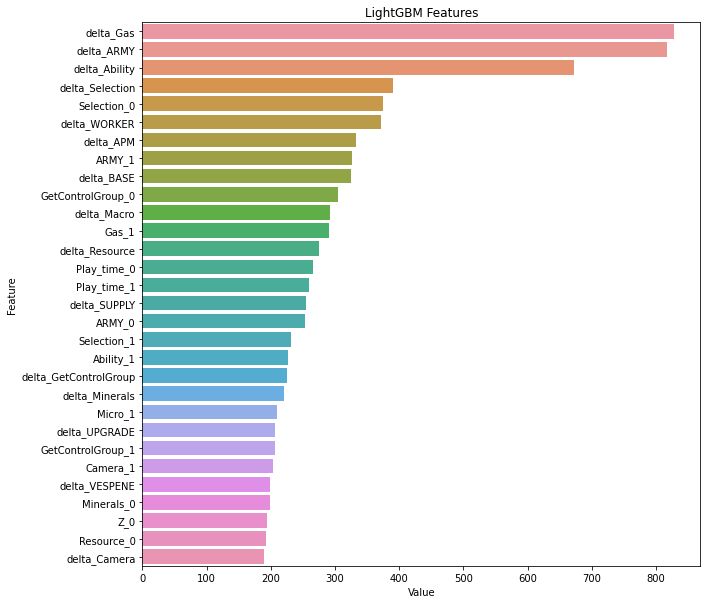

In [190]:
from lightgbm import LGBMRegressor
params = {
        'objective':'regression',
        'metric':'auc',
        'learning_rate':0.01,
        'n_estimators': 500,
}

model = LGBMRegressor(**params)
model.fit(
    train_x, train_y,
    eval_set=[(val_x, val_y)],
    eval_metric='auc',
    verbose=100,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, train_x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_importance.sort_values(by="Value", ascending=False)[:30])
plt.title('LightGBM Features')
plt.show()

## Dendrogram (correlation of features)

In [191]:
'''
import scipy

# Keep only significant features
to_keep = feature_importance.sort_values(by='Value', ascending=False)[:50].Feature

## Create a Dendrogram to view highly correlated features
corr = np.round(scipy.stats.spearmanr(train_x[to_keep]).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(14,20))
dendrogram = hc.dendrogram(z, labels=train_x[to_keep].columns, orientation='left', leaf_font_size=16)
plt.plot()
'''

"\nimport scipy\n\n# Keep only significant features\nto_keep = feature_importance.sort_values(by='Value', ascending=False)[:50].Feature\n\n## Create a Dendrogram to view highly correlated features\ncorr = np.round(scipy.stats.spearmanr(train_x[to_keep]).correlation, 4)\ncorr_condensed = hc.distance.squareform(1-corr)\nz = hc.linkage(corr_condensed, method='average')\nfig = plt.figure(figsize=(14,20))\ndendrogram = hc.dendrogram(z, labels=train_x[to_keep].columns, orientation='left', leaf_font_size=16)\nplt.plot()\n"

## Feature Importance

In [192]:
'''
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42).fit(val_x, val_y)
eli5.show_weights(perm, feature_names=list(val_x.columns))
'''

'\nimport eli5\nfrom eli5.sklearn import PermutationImportance\n\nperm = PermutationImportance(model, random_state=42).fit(val_x, val_y)\neli5.show_weights(perm, feature_names=list(val_x.columns))\n'

In [193]:
'''
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(val_x)
shap.summary_plot(shap_values, val_x, feature_names=list(val_x.columns))
'''

'\nimport shap\nshap.initjs()\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(val_x)\nshap.summary_plot(shap_values, val_x, feature_names=list(val_x.columns))\n'

## Prediction model based on Deep learning

In [194]:
from keras import optimizers, regularizers
from keras.models import Sequential, Model, load_model 
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, Lambda
from keras.losses import mse, binary_crossentropy
from keras.models import Model
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from sklearn import preprocessing
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [195]:
def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10, verbose=0):
    ''' Wrapper function to create a LearningRateScheduler with step decay schedule. '''
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return tf.keras.callbacks.LearningRateScheduler(schedule, verbose)

In [196]:
# use_num_features = 0 인 경우 모든 컬럼의 데이터 사용
use_num_features = 0

scaler = preprocessing.StandardScaler()

if use_num_features:
    im_features = feature_importance.sort_values(by='Value', ascending=False)[:use_num_features].Feature 
    X_train = scaler.fit_transform(train_x[im_features].astype(np.float32))
    Y_train = train_y.values
    X_val = scaler.fit_transform(val_x[im_features].astype(np.float32))
    Y_val = val_y.values
else:
    X_train = scaler.fit_transform(train_x.astype(np.float32))
    Y_train = train_y.values
    X_val = scaler.fit_transform(val_x.astype(np.float32))
    Y_val = val_y.values

In [219]:
def get_model():
    penalties = 0.01
    stddev = 0.05

    hidden_layer = tf.keras.layers.GaussianNoise(stddev)(inputs)
    
    hidden_layer = tf.keras.layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(penalties))(hidden_layer)
    hidden_layer = tf.keras.activations.elu(hidden_layer)
    hidden_layer = tf.keras.layers.BatchNormalization()(hidden_layer)
    hidden_layer = tf.keras.layers.GaussianNoise(stddev)(hidden_layer)
    
    hidden_layer = tf.keras.layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(penalties))(hidden_layer)
    hidden_layer = tf.keras.activations.elu(hidden_layer)
    hidden_layer = tf.keras.layers.BatchNormalization()(hidden_layer)
    hidden_layer = tf.keras.layers.GaussianNoise(stddev)(hidden_layer)
    
    hidden_layer = tf.keras.layers.Dense(32, kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(penalties))(hidden_layer)
    hidden_layer = tf.keras.activations.elu(hidden_layer)
    hidden_layer = tf.keras.layers.BatchNormalization()(hidden_layer)
    hidden_layer = tf.keras.layers.GaussianNoise(stddev)(hidden_layer)

    outputs = tf.keras.layers.Dense(1, kernel_initializer='normal', activation='sigmoid')(hidden_layer) 
    
    #return tf.keras.Model(inputs, outputs)
    return outputs

''' 
# GaussianNoise
 inputs =  inputs + K.random_normal(shape=K.shape(inputs), mean=0, stddev=stddev)
 
# GaussianDropout
 stddev = np.sqrt(drop_rate / (1.0 - drop_rate))
 inputs =  inputs * K.random_normal(shape=K.shape(inputs), mean=1, stddev=stddev)
'''

' \n# GaussianNoise\n inputs =  inputs + K.random_normal(shape=K.shape(inputs), mean=0, stddev=stddev)\n \n# GaussianDropout\n stddev = np.sqrt(drop_rate / (1.0 - drop_rate))\n inputs =  inputs * K.random_normal(shape=K.shape(inputs), mean=1, stddev=stddev)\n'

In [220]:
display(len(X_train), len(X_train[0]))

31024

84

In [221]:
8  * strategy.num_replicas_in_sync * 16 * 4

4096

In [222]:
np.random.seed(0)
tf.random.set_seed(0)

epochs = 1000
lr = 0.01
batch_size = 4096

steps = len(X_train) // batch_size

optimizer = tf.keras.optimizers.Adam()

lr_sched = step_decay_schedule(initial_lr=lr, decay_factor=0.9, step_size=10, verbose=0)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=400, verbose=1)

callbacks_list = [lr_sched, early_stopping]

# Deep learning model
with strategy.scope():
    inputs = tf.keras.Input(shape=(X_train.shape[1],))
    output_lst = []
    
    outputs = get_model()
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    history = model.fit(
            X_train.astype(np.float32), Y_train.astype(np.float32),
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data = (X_val.astype(np.float32), Y_val.astype(np.float32)),
            #validation_split=0.15,
            steps_per_epoch=steps,
            callbacks=callbacks_list,
            verbose=0)
    
'''
# Setting save path 
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', 
                             verbose = 2, save_best_only = True, mode ='min', save_freq = 10)
                             
# Ensemble
outputs = tf.keras.layers.average(output_lst)
for i in range(15):
    model = get_model()
    y = model(inputs)
    output_lst.append(y)   
'''    

Epoch 00866: early stopping


"\n# Setting save path \ncheckpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' \ncheckpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', \n                             verbose = 2, save_best_only = True, mode ='min', save_freq = 10)\n                             \n# Ensemble\noutputs = tf.keras.layers.average(output_lst)\nfor i in range(15):\n    model = get_model()\n    y = model(inputs)\n    output_lst.append(y)   \n"

Max AUC score (Validation dataset):  0.69136715


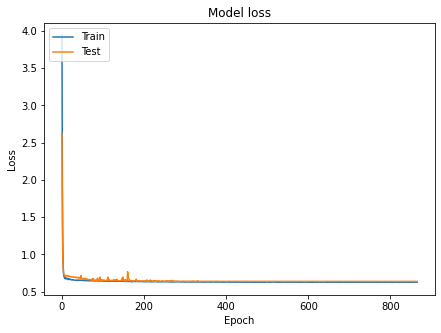

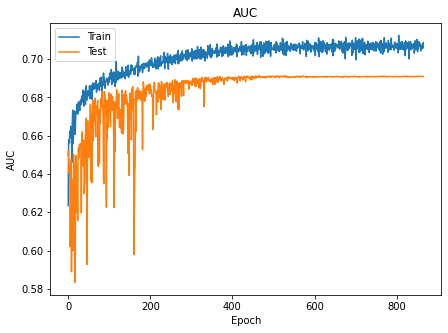

In [223]:
his = list(history.history)
print("Max AUC score (Validation dataset): ", max(history.history[his[3]]))

# Plot training & validation loss values
plt.figure(figsize=(7,5))
plt.plot(history.history[his[0]])
plt.plot(history.history[his[2]])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation auc score
plt.figure(figsize=(7,5))
plt.plot(history.history[his[1]])
plt.plot(history.history[his[3]])
plt.title('AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 6. Submission

In [204]:
# 게임 플레이 시간이 0분인 유저 제거

def check(data):
    g = data.groupby(['game_id', 'player'])
    m_time = g.time.max()
   
    df = pd.DataFrame()
    gameIds = data['game_id'].unique()
    
    id_lst = []
    winner_lst = []
    
    for gameId in tqdm(gameIds):
        if (m_time[gameId].min() <= 0) or (m_time[gameId].max() <= 0): # 한쪽 선수의 플레이 기록이 없는 경우, 추가 안함 (테스트셋에서 다시 고려)
            player_time = m_time[gameId]
            id_lst.append(gameId)
            winner_lst.append(np.where(player_time[0] >= player_time[1], 0, 1))
            
    df['game_id'] = id_lst
    df['winner'] = winner_lst
    
    return df

In [205]:
origin_test = pd.read_feather("/kaggle/input/star2-dataset/test.ftr")
origin_test = reduce_mem_usage(origin_test)
test_df = check(origin_test)

test = pd.read_feather("/kaggle/input/star2-processed-dataset/processed_test2.ftr")
test = reduce_mem_usage(test)
display(test.head())

Memory usage of dataframe is 903.69 MB --> 903.69 MB (Decreased by 0.0%)


100%|██████████| 16787/16787 [00:18<00:00, 930.95it/s]


Memory usage of dataframe is 10.19 MB --> 2.64 MB (Decreased by 74.1%)


,game_id,VESPENE_0,SUPPLY_0,WORKER_0,BASE_0,BUILDING_0,DEFENSE_0,ARMY_0,UPGRADE_0,Minerals_0,Gas_0,Supply_0,Control_key_0,Ability_0,AddToControlGroup_0,Camera_0,ControlGroup_0,GetControlGroup_0,Right Click_0,Selection_0,SetControlGroup_0,Micro_0,Macro_0,APM_0,Player_sight_0,Resource_0,Play_time_0,P_0,T_0,Z_0,VESPENE_1,SUPPLY_1,WORKER_1,BASE_1,BUILDING_1,DEFENSE_1,ARMY_1,UPGRADE_1,Minerals_1,Gas_1,Supply_1,Control_key_1,Ability_1,AddToControlGroup_1,Camera_1,ControlGroup_1,GetControlGroup_1,Right Click_1,Selection_1,SetControlGroup_1,Micro_1,Macro_1,APM_1,Player_sight_1,Resource_1,Play_time_1,P_1,T_1,Z_1,delta_VESPENE,delta_SUPPLY,delta_WORKER,delta_BASE,delta_BUILDING,delta_DEFENSE,delta_ARMY,delta_UPGRADE,delta_Minerals,delta_Gas,delta_Supply,delta_Control_key,delta_Ability,delta_AddToControlGroup,delta_Camera,delta_ControlGroup,delta_GetControlGroup,delta_Right Click,delta_Selection,delta_SetControlGroup,delta_Micro,delta_Macro,delta_APM,delta_Player_sight,delta_Resource,delta_Play_time
0,38872,2,2,11,0,4,0,2,0,1725,550,15.00,6,31,1,232,0,9,241,52,5,21,21,345,1419.00,2275,7.06,1.00,0.00,0.00,2,5,12,1,3,3,4,0,2925,300,20.00,4,38,4,467,0,43,122,41,0,51,30,252,1767.00,3225,7.04,1.00,0.00,0.00,0,3,1,1,-1,3,2,0,1200,-250,5.00,-2,7,3,235,0,34,-119,-11,-5,30,9,-93,348.00,950,-0.02
1,38873,0,6,7,5,1,0,5,1,3000,250,14.00,2,34,0,200,4,18,51,114,0,24,25,223,753.00,3250,6.07,0.00,0.00,1.00,0,4,13,1,5,1,4,0,2725,350,21.00,0,28,1,146,0,122,68,19,5,128,28,243,642.00,3075,6.07,1.00,0.00,0.00,0,-2,6,-4,4,1,-1,-1,-275,100,7.00,-2,-6,1,-54,-4,104,17,-95,5,104,3,20,-111.00,-175,0.00
2,38874,2,3,9,1,2,0,3,0,1600,350,14.00,9,33,0,245,0,63,79,42,7,79,20,233,972.00,1950,4.41,0.00,1.00,0.00,2,3,5,1,1,0,2,0,1250,200,10.00,6,29,0,220,0,426,108,36,5,437,14,610,984.00,1450,4.40,0.00,1.00,0.00,0,0,-4,0,-1,0,-1,0,-350,-150,-4.00,-3,-4,0,-25,0,363,29,-6,-2,358,-6,377,12.00,-500,-0.01
3,38875,2,6,21,2,7,2,10,2,4000,850,37.00,18,95,8,515,0,255,218,123,9,290,52,726,2199.00,4850,7.58,0.00,1.00,0.00,0,4,19,1,6,0,4,1,3250,475,28.00,17,58,1,357,0,24,322,99,2,44,35,523,2037.00,3725,7.57,1.00,0.00,0.00,-2,-2,-2,-1,-1,-2,-6,-1,-750,-375,-9.00,-1,-37,-7,-158,0,-231,104,-24,-7,-246,-17,-203,-162.00,-1125,-0.01
4,38876,2,0,4,0,0,0,0,0,250,0,4.00,1,7,2,129,0,387,30,25,2,392,6,454,477.00,250,2.50,0.00,0.00,1.00,2,1,2,0,1,0,1,1,575,100,2.50,0,8,0,161,0,1,7,35,1,2,8,52,504.00,675,2.48,0.00,0.00,1.00,0,1,-2,0,1,0,1,1,325,100,-1.50,-1,1,-2,32,0,-386,-23,10,-1,-390,2,-402,27.00,425,-0.02


In [ ]:
X_test = test.drop(['game_id'], axis=1)
X_test = scaler.fit_transform(X_test.astype(np.float32))

# Predict using DNN
pred = model.predict(X_test.astype(np.float32)) # .ravel()
print('Prediction values range: {0} ~ {1}'.format(pred.min(), pred.max()))

test['winner'] = pred
test_result = test[['game_id', 'winner']]

submission = test_result.append(test_df, ignore_index=True).sort_values(by='game_id')
submission.to_csv('submission.csv', index=False)

## Check of submission file

In [ ]:
# Last check of submission
print('Head of submission: ')
display(submission.head())